# Testing CAE Classifier #

In this notebook we assess the performance of the convolutional autoencoder classifier on the test set of 120 images by Van Gogh, Rembrandt, and Renoir.

In [29]:
# import modules
import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from utils.get_model import *
from utils.image_formatting import *
from utils.evaluate import *
from utils.models import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# load trained autoencoder 
ae = tf.keras.models.load_model('models/autoencoder_all_data_1000')
ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 256, 256, 10)      760       
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 128, 128, 10)      0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 128, 128, 20)      5020      
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 64, 64, 20)        0         
_________________________________________________________________
UpSample_1 (UpSampling2D)    (None, 128, 128, 20)      0         
_________________________________________________________________
Conv2DTrans_1 (Conv2DTranspo (None, 128, 128, 20)      10020     
_________________________________________________________________
UpSample_2 (UpSampling2D)    (None, 256, 256, 20)      0

In [37]:
# get test set
# artists = ['claude-monet', 'pablo-picasso', 'vincent-van-gogh']
artists = ['rembrandt', 'pierre-auguste-renoir', 'vincent-van-gogh']

X, y = preprocess_images2(artists=artists, n_imgs=1000, test_set=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(102, 256, 256, 3) (102,)
(12, 256, 256, 3) (12,)


In [38]:
# build CAE from AE
cae = build_cae(ae)

Model: "cae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 256, 256, 10)      760       
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 128, 128, 10)      0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 128, 128, 20)      5020      
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 64, 64, 20)        0         
_________________________________________________________________
classifier (Sequential)      (None, 3)                 32849203  
Total params: 32,854,983
Trainable params: 32,849,203
Non-trainable params: 5,780
_______________________________________________

Here we train the classifier using an early stopping callback where training is stopped when the validation accuracy is greater than 80%. This callback `accuracy_callback()` is defined in `utils/models`.

In [39]:
# train classifier
cae_training_history = cae.fit(x=X_train, y=y_train, batch_size=32, epochs=18, validation_data=(X_val, y_val), callbacks=[accuracy_callback()])

Epoch 1/18
4/4 [==============================] - 1s 218ms/step - loss: 9068.1025 - accuracy: 0.4020 - val_loss: 3608.7053 - val_accuracy: 0.2500
Epoch 2/18
4/4 [==============================] - 1s 199ms/step - loss: 1914.2350 - accuracy: 0.3627 - val_loss: 387.7514 - val_accuracy: 0.3333
Epoch 3/18
4/4 [==============================] - 1s 194ms/step - loss: 650.3869 - accuracy: 0.5392 - val_loss: 31.1588 - val_accuracy: 0.7500
Epoch 4/18
4/4 [==============================] - 1s 196ms/step - loss: 520.0447 - accuracy: 0.6275 - val_loss: 356.3115 - val_accuracy: 0.5833
Epoch 5/18
4/4 [==============================] - 1s 195ms/step - loss: 438.5181 - accuracy: 0.6078 - val_loss: 141.9484 - val_accuracy: 0.7500
Epoch 6/18
4/4 [==============================] - 1s 196ms/step - loss: 357.7480 - accuracy: 0.6667 - val_loss: 170.4377 - val_accuracy: 0.6667
Epoch 7/18
4/4 [==============================] - ETA: 0s - loss: 204.3129 - accuracy: 0.7451{'loss': 204.3128662109375, 'accuracy': 0

INFO:tensorflow:Assets written to: models/cae_3PainterCAE_2021-04-23-16-25/assets


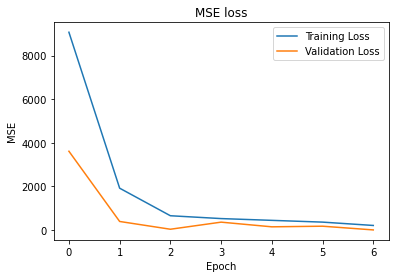

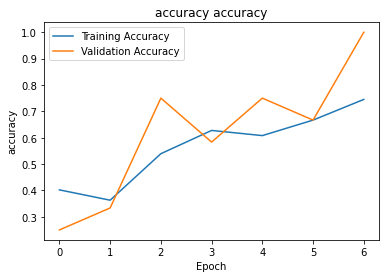

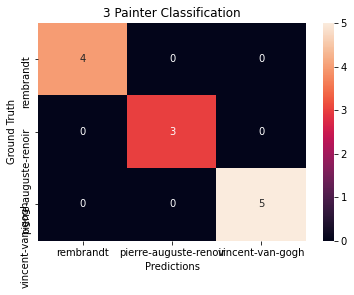

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



<Figure size 432x288 with 0 Axes>

In [41]:
# assess classifier
timestamp = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
cae_path = 'models/cae_3PainterCAE_{}'.format(timestamp)
cae.save(cae_path)

make_training_plot(cae_training_history,
                   type='loss', metric='MSE', 
                   filename='cae_3PainterCAE_loss_{}'.format(timestamp))

make_training_plot(cae_training_history,
                   type='accuracy', metric='accuracy', 
                   filename='cae_3PainterCAE_accuracy_{}'.format(timestamp))

predictions = tf.argmax(cae.predict(X_val), axis=1)         # generate predictions

report, _ = make_confusion_matrix(predictions, y_val, "3 Painter Classification", timestamp, artists, 'cae_3PainterCAE')

print(report)

### 10 Fold Validation ###

To assess the performance of our classifier, we perform 10 fold validation. For each of the 10 iterations, a random selection of 10% of the test set is used for validation, and the remaining 90% is used for training of the classifier. For each classifier, we calculate the precision, recall, and F1 score. These metrics are then averaged accross all classifiers to give the aggregate performance of our model.


Reached 80.00% accuracy, training done.

Reached 80.00% accuracy, training done.

Reached 80.00% accuracy, training done.

Reached 80.00% accuracy, training done.

Reached 80.00% accuracy, training done.
Precision:  0.778
Recall:  0.725
F1 Score:  0.719


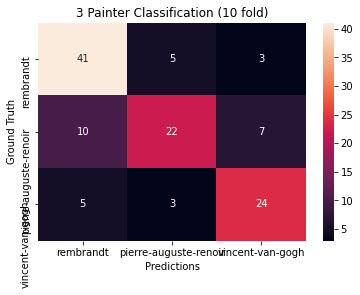

<Figure size 432x288 with 0 Axes>

In [44]:
# 10 fold validation 
results = []
ae = tf.keras.models.load_model('models/autoencoder_all_data_1000')
artists = ['rembrandt', 'pierre-auguste-renoir', 'vincent-van-gogh']
X, y = preprocess_images2(artists=artists, n_imgs=1000, test_set=True)
predictions = []
labels = []

for k in range(10):
    cae = build_cae(ae, summary=False)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=k)
    
    cae_training_history = cae.fit(x=X_train, y=y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val), verbose=0, callbacks=[accuracy_callback()])
    prediction = tf.argmax(cae.predict(X_val), axis=1)         # generate predictions
    labels.append(y_val)
    predictions.append(prediction)
    _, report_dict = make_confusion_matrix(prediction, y_val, "3 Painter Classification", "", artists, 'cae_3PainterCAE', display_matrix=False, save_matrix=False)
    results.append(report_dict)
    
make_k_fold_results(results)

predictions = np.array(predictions).flatten()
labels = np.array(labels).flatten()
report, _ = make_confusion_matrix(predictions, labels, "3 Painter Classification (10 fold)", "", artists, "3_painter_10_fold")